In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
from scipy.signal import detrend
import pandas as pd
from datetime import datetime
from eofs.xarray import Eof

In [2]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [93]:
#load observational SST
hadsst = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_sst.nc", chunks = {'time':12}).sst
hadsst = hadsst.sortby(hadsst.latitude, ascending=True)
#rename coords
#hadsst = hadsst.rename({"lon": "longitude", "lat": "latitude"})
hadsst =hadsst.sel(time = slice("1950-01-01", "2022-12-31"))
hadsst = hadsst.compute()

In [94]:
hadsst1 = xr.where(hadsst == -1000, np.nan, hadsst)

In [95]:
def roll_lon(df):
    df.coords['longitude'] = (df.coords['longitude'] + 360) % 360# - 180
    df = df.sortby(df.longitude)
    return df

In [96]:
hadsst1 = roll_lon(hadsst1)

In [97]:
def ssta(DS):
    clim = DS.sel(time = slice("1990-01-01", "2005-12-31")).groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def NINO34_sst(DS):
    return (DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
def NINO3(DS):
    return ssta(DS).sel(latitude=slice(
         -5, 5),longitude=slice(210, 270)).mean(['latitude', 'longitude'])
def NINO34(DS):
    return ssta(DS).sel(latitude=slice(
         -5, 5),longitude=slice(190, 240)).mean(['latitude', 'longitude'])
def NINO4(DS):
    return ssta(DS).sel(latitude=slice(
         -5, 5),longitude=slice(160, 210)).mean(['latitude', 'longitude'])
def DMI(DS):
    WTIO =  ssta(DS).sel(latitude=slice(
         -10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO =  ssta(DS).sel(latitude=slice(
         -10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return (WTIO - SETIO)

In [98]:
def Modoki(DS):
    boxa = ssta(DS).sel(latitude=slice(
        -10, 10),longitude=slice(165, 220)).mean(['latitude', 'longitude'])
    boxb = ssta(DS).sel(latitude=slice(
        -15, 5),longitude=slice(250, 290)).mean(['latitude', 'longitude'])
    boxc = ssta(DS).sel(latitude=slice(
        -10, 20),longitude=slice(125, 145)).mean(['latitude', 'longitude'])
    return (boxa - (0.5*boxb) - (0.5*boxc))

In [99]:
def EP_CP_index(DS):
    sst_anom = ssta(DS)
    sst_anom = sst_anom.sel(longitude = slice(140, 280), latitude = slice(-15,15))
    coslat = np.cos(np.deg2rad(sst_anom.coords['latitude'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(sst_anom, weights=wgts)
    pc1 = solver.pcs(npcs=2, pcscaling=1)
    EP = (pc1[:,0]+pc1[:,1])/np.sqrt(2)
    CP = (pc1[:,0]-pc1[:,1])/np.sqrt(2)
    return EP,CP

In [100]:
def EPI_CPI(DS):
    #define Nino3 and Nino4
    n3 = NINO3(DS)
    n4 = NINO4(DS)
    alpha = xr.where(n3 * n4 > 0, 0.4, 0)

    # Calculate EPI and CPI
    EPI = n3 - alpha * n4
    CPI = n4 - alpha * n3
    return EPI, CPI


In [101]:
def EP_CP_events(DS):
    EP, CP = EP_CP_index(DS)
    # Select SON seasons into a timeseries
    E_DJF = EP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"]
    C_DJF = CP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"]
    #get the Ep and CP events
    TH_E = E_DJF.std()
    EP_e = E_DJF.where(E_DJF > TH_E.values).dropna(dim="time")
    TH_C = C_DJF.std()
    CP_e = C_DJF.where(C_DJF > TH_C.values).dropna(dim="time")
    return EP_e.groupby('time.year').mean("time").year, CP_e.groupby('time.year').mean("time").year

In [102]:
def EPI_CPI_events(DS):
    EPI, CPI = EPI_CPI(DS)
    # Select SON seasons into a timeseries
    E_SON = EPI.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["SON"]
    C_SON = CPI.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["SON"]
    #get the Ep and CP events
    TH_E = 0.6*E_SON.std()
    EP_e = E_SON.where(E_SON > TH_E.values).dropna(dim="time")
    TH_C = 0.6*C_SON.std()
    CP_e = C_SON.where(C_SON > TH_C.values).dropna(dim="time")
    return EP_e.groupby('time.year').mean("time").year, CP_e.groupby('time.year').mean("time").year

In [103]:
def KUG_events(DS):
    #calculate N3 and N4 index
    n3 = NINO3(DS)
    n4 = NINO4(DS)
    #standardise
    n3 = n3/abs(n3).max()
    n4 = n4/abs(n4).max()
    # go to Quarterly timesiers
    n3 = n3.resample(time='QS-DEC').mean(dim="time")
    n4 = n4.resample(time='QS-DEC').mean(dim="time")
    # Select DJF seasons into a timeseries
    n3DJF = n3.groupby('time.season')["DJF"]
    n4DJF = n4.groupby('time.season')["DJF"]
    # Initialize lists to hold the indices of WP and CT El Nino events
    wp_el_nino_events = []
    ct_el_nino_events = []

    # Iterate over the time dimension
    for t in n3DJF.time:
    # Check for WP El Nino condition
        if n4DJF.sel(time = t) > n4.std() and n4DJF.sel(time = t) > n3DJF.sel(time = t):
            wp_el_nino_events.append(t)

        # Check for CT El Nino condition
        if n3DJF.sel(time = t) > n3.std() and n3DJF.sel(time = t) > n4DJF.sel(time = t):
            ct_el_nino_events.append(t)

    return xr.concat(wp_el_nino_events, dim = "time").groupby('time.year').mean("time").year, xr.concat(ct_el_nino_events, dim = "time").groupby('time.year').mean("time").year
    

In [104]:
WP, CT = KUG_events(hadsst1)

In [105]:
WP

<xarray.DataArray 'year' (year: 6)>
array([1957, 1968, 1994, 2009, 2014, 2019])
Coordinates:
  * year     (year) int64 1957 1968 1994 2009 2014 2019

In [106]:
EPI, CPI = EPI_CPI_events(hadsst1)

In [107]:
CPI

<xarray.DataArray 'year' (year: 8)>
array([1977, 1987, 1994, 2002, 2004, 2009, 2018, 2019])
Coordinates:
  * year     (year) int64 1977 1987 1994 2002 2004 2009 2018 2019

In [108]:
EP, CP = EP_CP_events(hadsst1)

In [119]:
EP

<xarray.DataArray 'year' (year: 8)>
array([1965, 1972, 1976, 1982, 1986, 1991, 1997, 2015])
Coordinates:
  * year     (year) int64 1965 1972 1976 1982 1986 1991 1997 2015

In [110]:
#lets make a DJF composite of SSTA for all these events and see what it looks like

In [111]:
SST_anom = ssta(hadsst1)
#get DJF 
SST_anom = SST_anom.resample(time='QS-DEC').mean(dim="time")
SST_anom = SST_anom.groupby('time.season')["DJF"].groupby('time.year').mean('time')

In [139]:
SSTA_anom_CP = SST_anom.where(SST_anom.year == CP)
SSTA_anom_CPI = SST_anom.where(SST_anom.year == CPI)
SSTA_anom_WP = SST_anom.where(SST_anom.year == WP)

In [153]:
#find longitude of max anomaly alng -5+5
test = SSTA_anom_CPI.sel(latitude = slice(-5,5), longitude = slice(120,280)).mean('latitude')

In [154]:
zonal_gradient = np.gradient(test, axis=test.get_axis_num('longitude'))

# Convert the gradient to a DataArray
zonal_gradient_da = xr.DataArray(zonal_gradient, coords=test.coords)

# 4. Find the Longitude of Maximum Gradient
max_gradient_longitude = zonal_gradient_da.idxmax(dim='longitude')

In [155]:
max_gradient_longitude

<xarray.DataArray 'longitude' (year: 8)>
array([159.5, 159.5, 144.5, 144.5, 163.5, 188.5, 155.5, 159.5],
      dtype=float32)
Coordinates:
  * year     (year) int64 1977 1987 1994 2002 2004 2009 2018 2019

In [156]:
dmi = DMI(hadsst1)

In [157]:
dmi = dmi.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["SON"].groupby('time.year').mean('time')

In [158]:
DMI_CPI = dmi.where(dmi.year == CPI)


AttributeError: 'PathCollection' object has no property 'col'

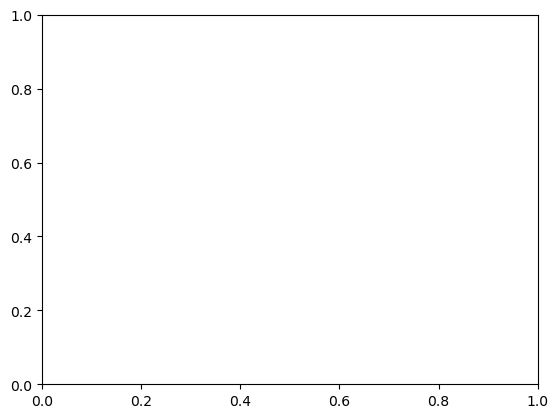

In [160]:
plt.scatter(max_gradient_longitude, DMI_CPI, col = 'year')

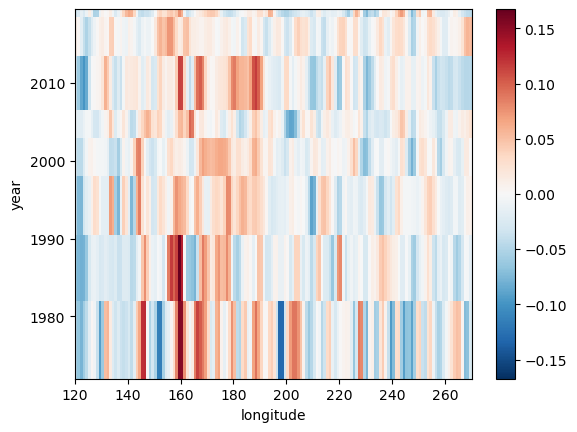

In [147]:
zonal_gradient_da.plot()

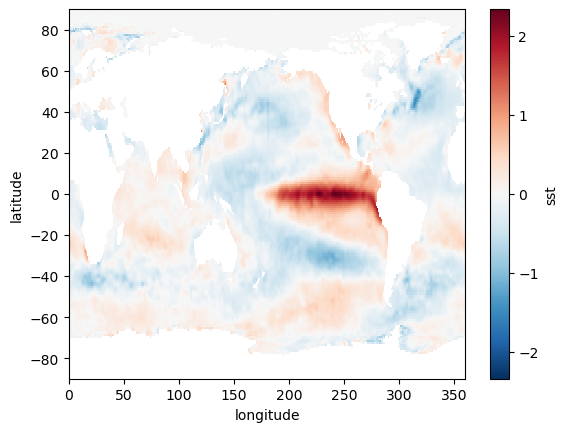

In [112]:
SST_anom.where(SST_anom.year == EP).mean("year").plot()

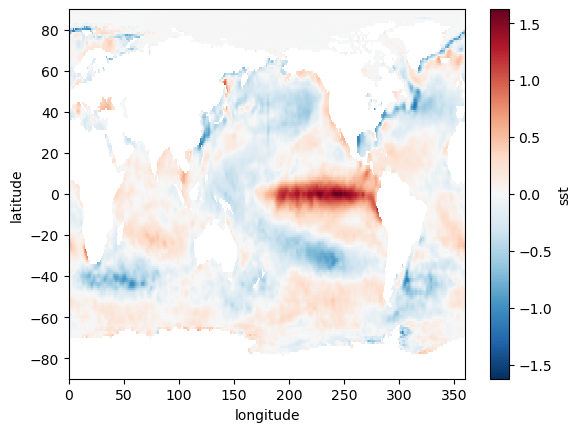

In [113]:
SST_anom.where(SST_anom.year == EPI).mean("year").plot()

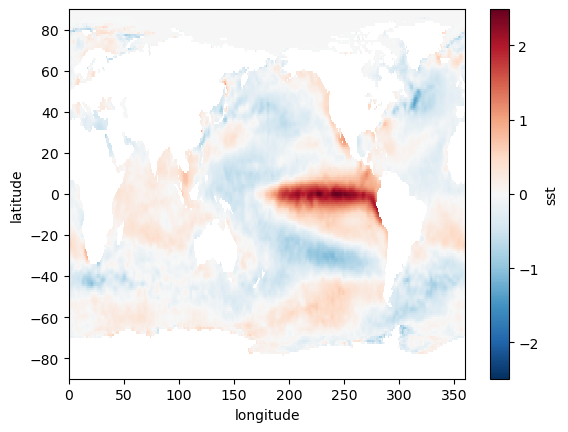

In [114]:
SST_anom.where(SST_anom.year == CT).mean("year").plot()

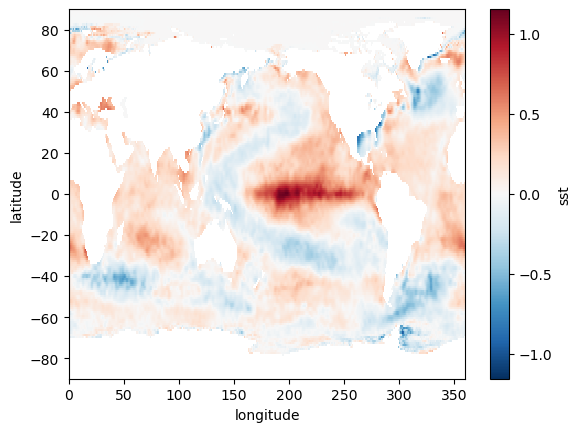

In [115]:
SST_anom.where(SST_anom.year == CP).mean("year").plot()

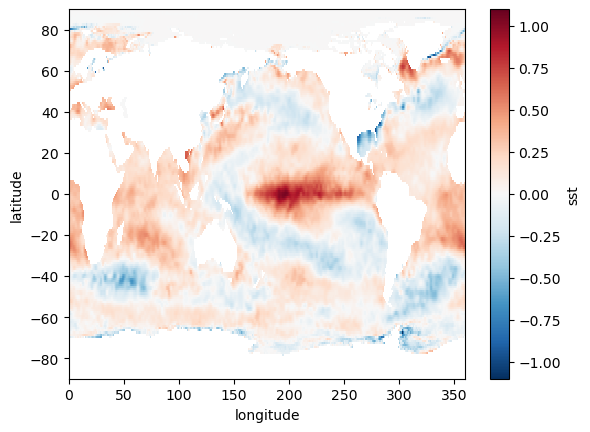

In [116]:
SST_anom.where(SST_anom.year == CPI).mean("year").plot()

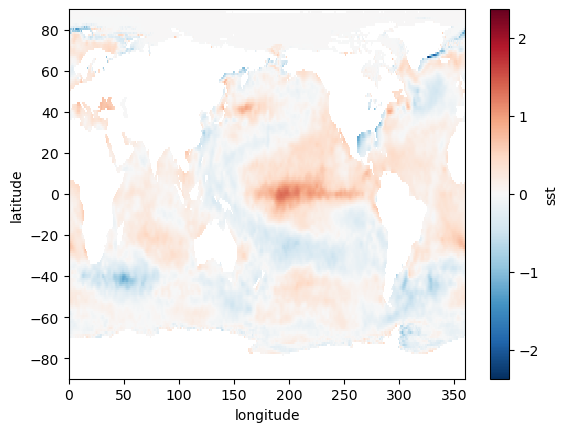

In [117]:
SST_anom.where(SST_anom.year == WP).mean("year").plot()